# Convert Translation LNM to Rotation LNM Model

In [1]:
from obspy import * 
from pandas import *
from os import listdir, uname

import netCDF4 as nc
import numpy as np
import pygmt 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Citation: global_land_mask package

Karin, Todd. Global Land Mask. October 5, 2020. https://doi.org/10.5281/zenodo.4066722

In [2]:
from global_land_mask import globe

## Configurations

In [3]:
config = {}

config['hostname'] = uname()[1]

if config['hostname'] == 'kilauea':
    config['workdir'] = "/export/data/LNM/data/"
    config['outdir_figures'] = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"    
elif config['hostname'] == 'lighthouse':
    config['workdir'] = "/home/andbro/kilauea-data/LNM/data/"
    config['outdir_figures'] = "/home/andbro/Documents/ROMY/LowNoiseModel/figures/"
else: 
    print(f"Hostname: {config['hostname']} not known!")
    
    
config['type'] = "RAYLEIGH" ## LOVE | RAYLEIGH

config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

if config['type'] == "RAYLEIGH":
    config['outdata'] = config['workdir']+"PHASE_VELOCITY_MODEL/"+"Rayleigh_Average/"
elif config['type'] == "LOVE":
    config['outdata'] = config['workdir']+"PHASE_VELOCITY_MODEL/"+"Love_Average/"
    
config['plot_station'] = "all"



In [4]:
def __makeplot_map(config, coordinates):
    
    topo_data = '@earth_relief_06m'

    # minlon, maxlon, minlat, maxlat = (-180, 180, -70, 70)


    fig = pygmt.Figure()

    pygmt.config(FONT_ANNOT="8p,Helvetica,black")
    pygmt.config(FONT_LABEL="8p,Helvetica,black")

    reg  = 'g' # [minlon, maxlon, minlat, maxlat]
    proj = "Kf0/10c"

    # make color pallets
    pygmt.makecpt(
        cmap='geo',
        series='-8000/8000/1000',
        continuous=True,
    )

    fig.grdimage(
        grid=topo_data,
        region=reg,
        projection=proj,
        shading=True,
        frame=False,
    )

    fig.coast(
        region=reg,
        projection=proj,
        shorelines=True,
        frame=["WSNE","af"],
        resolution="c",
    )
            
    fig.plot(
        x=coordinates['longitude'].astype(float),
        y=coordinates['latitude'].astype(float),
        style='c0.02c',
        color='red',
        pen='red',
        no_clip=True,
#         label=stations['name'],
    )
    

    fig.colorbar(
        frame='+l"Topography (m)"',
        position="x5c/-0.6c+w6c+jTC+h",
    )

    
    fig.show(width=1500);

    return fig

### Read veloctiy profiles

In [5]:
def __read_velocities_nc(path, fname):
    
    print(f"\nreading {path}{fname}")
    
    f = nc.Dataset(str(path)+str(fname),'r')
    
#     for key in f.variables.keys():
#            print(key)
            
#     print(f.dimensions)          
#     print(f.variables['period'][:])

    lats = np.array(f.variables['latitude'][:])
    lons = np.array(f.variables['longitude'][:])

    vphase = f.variables['vel'][:]
#     vphase.shape (57, 91, 181)
    # 57 periods: 0.1 to 300 sec 
    # on a grid for lon lat
        
    period = f.variables['period']
    
    return vphase, period, (lats, lons)

In [6]:
if config['type'] == "RAYLEIGH":
    vphase, period, coords = __read_velocities_nc(config["workdir"], config["rayleigh_phase_nc"]);
elif config['type'] == "LOVE":
    vphase, period, coords = __read_velocities_nc(config["workdir"], config["love_phase_nc"]);


reading /export/data/LNM/data/PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc


### Compute statistical measures

Compute median and mean spectra as well as a standard deviation of set of daily power spectra for the station.

In [7]:
def __get_stats(arr, axis=1):

    med, men, std = [],[],[]
    nan_found = False

    arr_new = []
    for i in range(-180,180,1):
        for j in range(-90,90,1):
            arr_new.append(arr[:,j,i].data)
    arr_new = np.array(arr_new)
    
    for fcross in range(arr_new.shape[axis]):
        if axis == 0:
            data = arr_new[fcross,:]
        elif axis == 1:
            data = arr_new[:,fcross]
        if np.isnan(data).any():
            nan_found = True
            data = data[~np.isnan(data)]
            
        men.append(np.mean(data))
        med.append(np.median(data))
        std.append(np.std(data))

    if nan_found:
        print(" -> NaN values were detected and ignored!")

    return np.array(med), np.array(men), np.array(std), np.array(arr_new)

In [8]:
vphase_median, vphase_mean, vphase_std, vphase_all = __get_stats(vphase, axis=1)


## convert km/s to m/s
# vphase_median *= 1000
# vphase_mean *= 1000
# vphase_std *=1000

In [9]:
def __plot_veloctiy_model(med, men, std):

    plt.figure(figsize=(15,5))

    plt.plot(period, med, color="red", label="median")
    plt.fill_between(period, y1=med-std, y2=med+std, color="red", alpha=0.5)

    plt.plot(period, men, color="blue", label="mean")
    plt.fill_between(period, y1=men-std, y2=men+std, color="blue", alpha=0.5)

    plt.xscale("log")
    
    plt.legend()
    
    plt.xlabel("Period (s)", fontsize=12)
    plt.ylabel("Phase Velocity (m/s)", fontsize=12)
    plt.title("Global Rayleigh Phase Velocties", fontsize=15)

    plt.show();

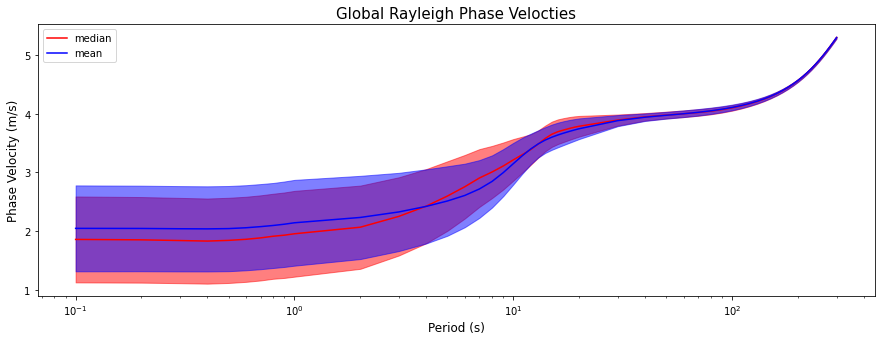

In [10]:
__plot_veloctiy_model(vphase_median, vphase_mean, vphase_std)

## Velocity Grid

In [11]:
def __get_masked_coordinates(longitudes, latitudes, mask="land"):
    
    lats, lons = [], []
    
    if len(latitudes.shape) == 2:
        N = int(longitudes.shape[0]*longitudes.shape[1])
        x, y = longitudes.reshape(N), latitudes.reshape(N)
    else:
        x, y = longitudes, latitudes
    
    if mask == "land":
        for lon, lat in zip(x,y):
            if globe.is_land(lat, lon):
                lons.append(lon)
                lats.append(lat)
    elif mask == "ocean":
        for lon, lat in zip(x,y):
            if globe.is_ocean(lat, lon):
                lons.append(lon)
                lats.append(lat)
    return lats, lons

In [12]:
vgrid_land = DataFrame()
vgrid_ocean = DataFrame()

Create a regular grid as the velocity data is sampled with every 2 degrees longitude and latitude

In [13]:
x_lats = np.array(range(-90, 92, 2))
y_lons = np.array(range(-180, 182, 2))

lat_grid, lon_grid = np.meshgrid(x_lats, y_lons)

Apply the land / ocean mask to the grid 

In [14]:
vgrid_land['latitude'], vgrid_land['longitude'] = __get_masked_coordinates(lon_grid, lat_grid, mask="land")

vgrid_ocean['latitude'], vgrid_ocean['longitude'] = __get_masked_coordinates(lon_grid, lat_grid, mask="ocean")

Plot the masked data as a check

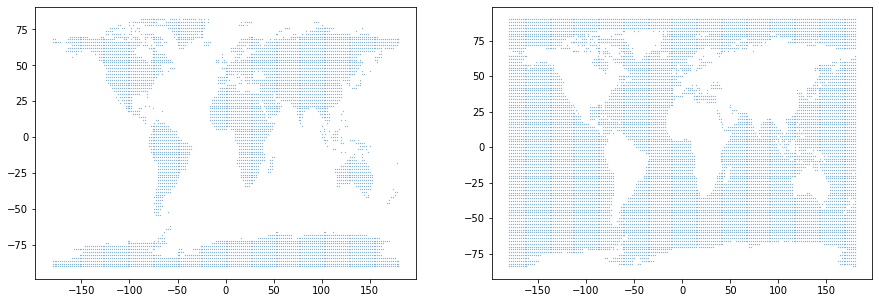

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(vgrid_land['longitude'], vgrid_land['latitude'], s=0.05)

ax[1].scatter(vgrid_ocean['longitude'], vgrid_ocean['latitude'], s=0.05)

plt.show();

Plot the masked grid points onto the map

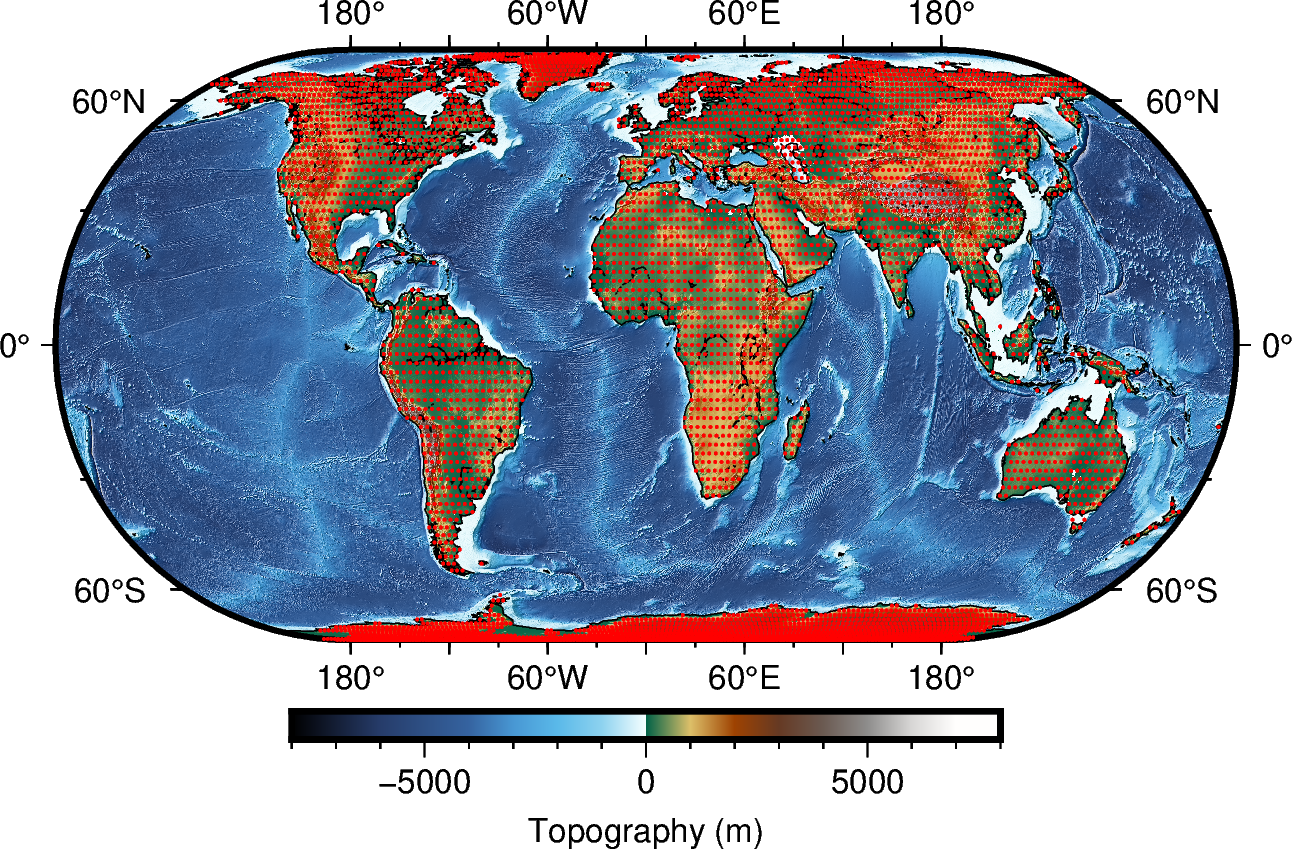

In [16]:
fig = __makeplot_map(config, vgrid_land)

## Change Grid

Changing grid since overly-represented at the poles. Trying to reduce it by distance along latitudes of about 111 km.

In [17]:
vgrid_land_new = DataFrame()
vgrid_ocean_new = DataFrame()

In [18]:
df = DataFrame()

## create new lists
lats, lons = [], []

## get maximal length
N = int(lon_grid.shape[0]*lon_grid.shape[1])

##reshape the grids to 1d arrays
df['lon'] = lon_grid.reshape(N)
df['lat'] = lat_grid.reshape(N)

## compute distance between grid points along latitudes -> 111 km * factor
factor = 4
d0 = 2*np.pi*6371/360 * factor

## interate over lattitudes (-90° to 90°)
for phi in df['lat'].unique():

    ## circumference at latitude
    u = 2*np.pi*np.cos(np.deg2rad(phi))*6371
    
    ## divided by distance -> amount of samples at latitude
    n = u/d0
    xth = round(181/n)
    
    ## reduce the grid accordingly by selecting every xth sample only
    tmp = df[df['lat'] == phi]
    tmp = tmp.iloc[::xth, :]
    
    ## add to lists
    for i, row in tmp.iterrows():
        lons.append(row['lon'])
        lats.append(row['lat'])

lats, lons = np.array(lats), np.array(lons)
del df, tmp

Plot new grid for a check

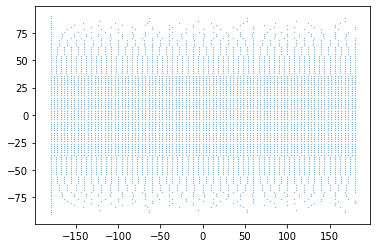

In [19]:
plt.scatter(lons, lats, s=0.05)

Apply land/ocean mask to grid

In [20]:
M = lons.shape[0]

lons, lats = lons.reshape(M), lats.reshape(M)

vgrid_land_new['latitude'], vgrid_land_new['longitude'] = __get_masked_coordinates(lons, lats, mask="land")

vgrid_ocean_new['latitude'], vgrid_ocean_new['longitude'] = __get_masked_coordinates(lons, lats, mask="ocean")

Plot new grid onto the map

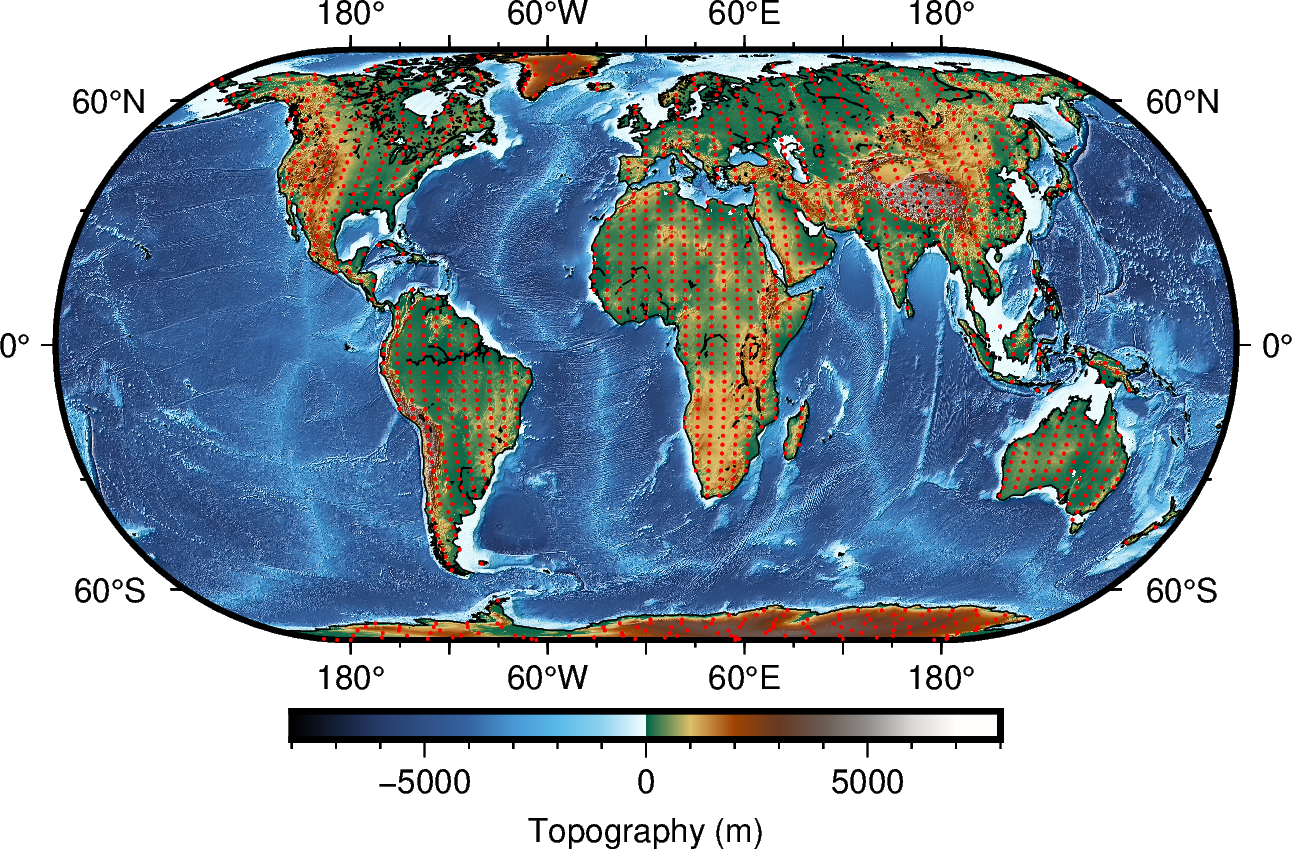

In [21]:
fig = __makeplot_map(config, vgrid_land_new)

In [22]:
# fig.savefig(config['outdir_figures']+"velocity_grid_resampled"+".png", anti_alias=True, dpi=300, transparent=None)

### Read station coordinates

In [23]:
# stations = read_csv(config['workdir']+"station_coordinates.csv")

In [24]:
# fig = __makeplot_map(config, stations)

### Extract Velocity Profiles according to Mask

Extract the velocity profiles at the new grid points.

In [25]:
def __extract_velocity_profiles(vphase, coords, vgrid):

    points = [(p_lon, p_lat) for p_lat, p_lon in zip(vgrid['latitude'], vgrid['longitude'])]
    count = 0
    vphase_selection = []
    for i, lon_grid_old in enumerate(coords[1]):
        for j, lat_grid_old in enumerate(coords[0]):
            if (lon_grid_old, lat_grid_old) in points:
                count +=1
                vphase_selection.append(vphase[:,j,i])

    if count != len(points):
        print(f"Profiles could not be extracted at all points of grid! \nmimatch: {count} <-> {len(points)}")
    
    return np.array(vphase_selection)

In [26]:
vphase_land = __extract_velocity_profiles(vphase, coords, vgrid_land_new)

In [27]:
vphase_ocean = __extract_velocity_profiles(vphase, coords, vgrid_ocean_new)

Calculate the statistics (median, mean and standard deviation)

In [28]:
def __get_stats2(arr):

    from scipy.stats import median_abs_deviation as mad

    med, men, std, mads = [],[],[],[]
    nan_found = False
 
    for fcross in range(arr[0].size):
        data = arr[:,fcross]
        if np.isnan(data).any():
            nan_found = True
            data = data[~np.isnan(data)]
            
        men.append(np.mean(data))
        med.append(np.median(data))
        std.append(np.std(data))
        mads.append(mad(data))

    if nan_found:
        print(" -> NaN values were detected and ignored!")

    return np.array(med), np.array(men), np.array(std), np.array(mads)

In [29]:
vphase_land_median, vphase_land_mean, vphase_land_std, vphase_land_mad = __get_stats2(vphase_land)

vphase_ocean_median, vphase_ocean_mean, vphase_ocean_std, vphase_ocean_mad = __get_stats2(vphase_ocean)

Create a final comparision plot of the 1D velocity models

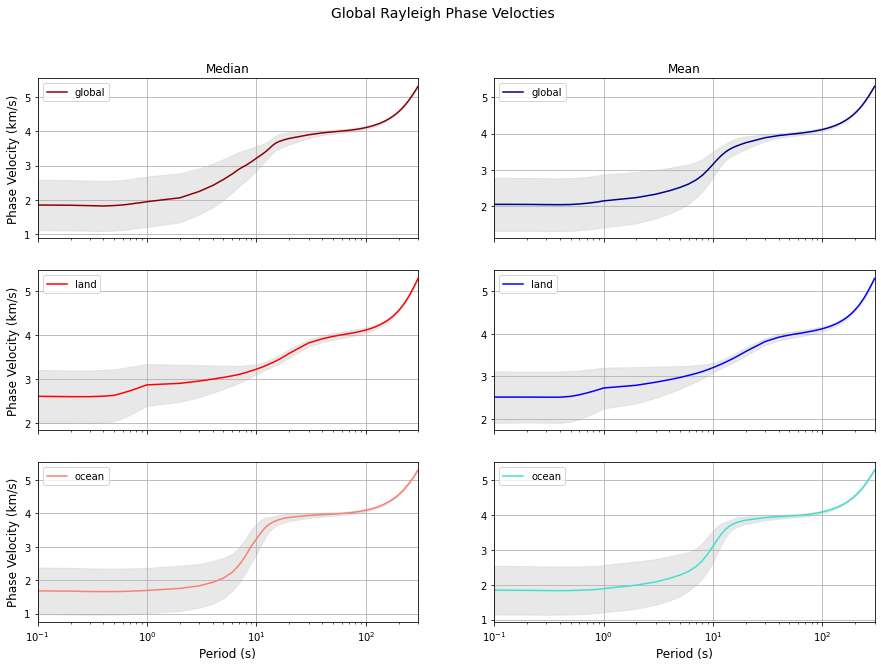

In [30]:
def __plot_overview():

    font = 12
    
    fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
    
    ## ____________________    
    data1, data2, std = vphase_median, vphase_mean, vphase_std 
    ax[0,0].plot(period,data1, color="darkred", label="global")
    ax[0,0].fill_between(period, y1=data1-std, y2=data1+std, color="lightgrey", alpha=0.5)

    ax[0,1].plot(period,data2, color="darkblue", label="global")
    ax[0,1].fill_between(period, y1=data2-std, y2=data2+std, color="lightgrey", alpha=0.5)

    ## ____________________
    data1, data2, std = vphase_land_median, vphase_land_mean, vphase_land_std 
    ax[1,0].plot(period,data1, color="red", label="land")
    ax[1,0].fill_between(period, y1=data1-std, y2=data1+std, color="lightgrey", alpha=0.5)

    ax[1,1].plot(period,data2, color="blue", label="land")
    ax[1,1].fill_between(period, y1=data2-std, y2=data2+std, color="lightgrey", alpha=0.5)
    
    ## ____________________
    data1, data2, std = vphase_ocean_median, vphase_ocean_mean, vphase_ocean_std 
    ax[2,0].plot(period,data1, color="salmon", label="ocean")
    ax[2,0].fill_between(period, y1=data1-std, y2=data1+std, color="lightgrey", alpha=0.5)

    ax[2,1].plot(period,data2, color="turquoise", label="ocean")
    ax[2,1].fill_between(period, y1=data2-std, y2=data2+std, color="lightgrey", alpha=0.5)

    
    ax[0,0].set_title("Median")
    ax[0,1].set_title("Mean")
        
    for i in range(3):
        ax[i,0].grid()
        ax[i,1].grid()
        ax[i,0].legend()
        ax[i,1].legend()
        ax[i,0].set_xscale('log')
        ax[i,1].set_xscale('log')
        ax[i,0].set_ylabel("Phase Velocity (km/s)", fontsize=font)
        
    ax[2,0].set_xlabel("Period (s)", fontsize=font)
    ax[2,1].set_xlabel("Period (s)", fontsize=font)

    ax[2,0].set_xlim([0.1,300])

    if config['type'] == "RAYLEIGH":
        plt.suptitle("Global Rayleigh Phase Velocties", fontsize=font+2)
    elif config['type'] == "LOVE":
        plt.suptitle("Global Love Phase Velocties", fontsize=font+2)
    
    plt.show()
    return fig

fig = __plot_overview();

In [31]:
if config['type'] == "RAYLEIGH":
    fig.savefig(config['outdir_figures']+"Rayleigh_velocity_models_comparison"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)
elif config['type'] == "LOVE":  
    fig.savefig(config['outdir_figures']+"Love_velocity_models_comparison"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

## Plot Propability Distribution

In [32]:
def __calculate_density(psd_array, bins=20, density=False, axis=1):

    from numpy import argmax, std, median, isnan, array, histogram, nan
    from scipy.stats import median_abs_deviation as mad
    
    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f"total spectra used: {psd_array.shape[0]}")

    
    ## find overall minimum and maxium values
    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])

    
    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []
    
    count = 0
    for h in range(len(psd_array[axis])):
        
        psd = psd_array[:,h]
        
        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);
                
        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        ## normalization
#         if  True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        DX = abs(max_value-min_value)/bins
        SUM = sum(hist)
        if str(round(SUM*DX,1)) != "1.0":
            print(round(SUM*DX,1))
            count+=1
        
        ## modify histogram with range increment
        hist = hist*DX
        
        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist)) 
        
        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion    
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = array(bin_mids)
    output['bins_maximas'] = array(bins_maximas)
    output['stds'] = array(stds)
    output['mads'] = array(mads)
    output['bins_medians'] = array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    
    if count > 0:
        print(f" {count} errors found for density computation!!!")
    
    return output

In [33]:
output = __calculate_density(vphase_land, bins=100, density=True)

In [42]:
def __makeplot_PPSD(ff, output, config, mode=None):

    from matplotlib import colors
    from numpy import ones, convolve, array, log10, roll, sqrt

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    

    y_axis = bins
    x_axis = ff

    ## plotting
    fig, ax = plt.subplots(1,1,figsize=(13,6))

    font=20

    cmap = plt.cm.get_cmap('magma_r')
#     cmap = plt.cm.get_cmap('gray_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
                    alpha=0.99,
                   )

    x_axis_mod = x_axis + (np.roll(x_axis,-1)-x_axis)/2; x_axis_mod[-1] = x_axis[-1] + (x_axis[-1]-x_axis[-2])/2
    plt.scatter(x_axis_mod, bins_maximas, s=2, color='darkgreen', ls="--", alpha=0.8, label="maximum")
#     plt.plot(x_axis_mod, bins_maximas, color='darkgreen', ls="--", alpha=0.8, label="maximum")
#     plt.plot(x_axis_mod, bins_medians, color='black', ls="-", alpha=0.8, label="median")

#     plt.fill_betweenx(range(-270, -140), x1=0, x2=2.5, color="grey", alpha=0.4)
#     plt.fill_betweenx(range(-270, -140), x1=200, x2=max(ff), color="grey", alpha=0.4)

    ## modify x-axis
    plt.xscale('log')
    plt.xlim([min(x_axis), max(x_axis)])
#     plt.xlim(1, 300)
    
    ## add colorbar
    caxes = fig.add_axes()
    cb = plt.colorbar(im, cax=caxes, alpha=1.0)
    cb.set_label("Propability Density", fontsize=font)
    
        
    plt.grid(axis="both", which="both", ls="--", alpha=0.7, zorder=0)
    plt.legend(fontsize=font-4)
    
    plt.xlabel("Period in seconds", fontsize=font)
    plt.ylabel("Phase Velocity in km/s", fontsize=font)
    
    
    if config['type'] == "RAYLEIGH":
        plt.title("Rayleigh Phase Velocties", fontsize=font+1)
    elif config['type'] == "LOVE":
        plt.title("Love Phase Velocties", fontsize=font+1)
    
    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

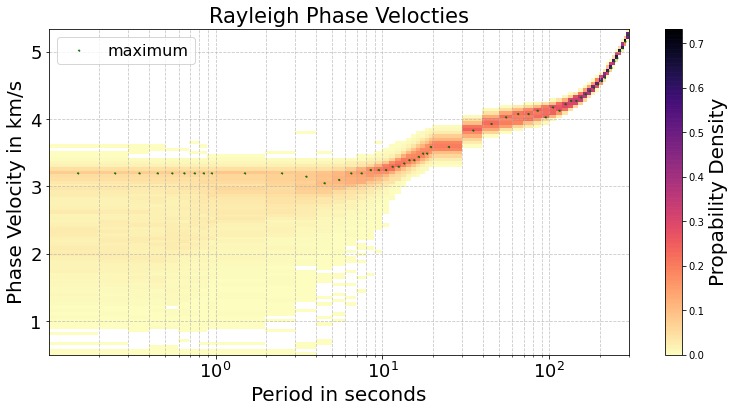

In [43]:
fig = __makeplot_PPSD(period[:], output, config, mode="ASD")

In [36]:
if config['type'] == "RAYLEIGH":
    fig.savefig(config['outdir_figures']+"Rayleigh_vphase_PD"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)
elif config['type'] == "LOVE":  
    fig.savefig(config['outdir_figures']+"Love_vphase_PD"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

### Write Data to Files

In [37]:
periods = np.array(period[:])
periods_mod = periods + (np.roll(periods,-1)-periods)/2; periods_mod[-1] = periods[-1] + (periods[-1]-periods[-2])/2

In [38]:
# df_land = DataFrame()

# df_land['periods'] = periods
# df_land['periods_mod'] = periods_mod
# df_land['vphase_max'] = output['bins_maximas']
# df_land['vphase_median'] = vphase_land_median
# df_land['vphase_mean'] = vphase_land_mean
# df_land['vphase_std'] = vphase_land_std
# df_land['vphase_mad'] = vphase_land_mad

# df_land.to_pickle(config['outdata']+config['type']+"_vphase_land_only.pkl")
# pritn(config['outdata']+config['type']+"_vphase_land_only.pkl")

In [40]:
# df_ocean = DataFrame()


# df_ocean['periods'] = period[:]
# df_ocean['periods_mod'] = periods_mod
# df_ocean['vphase_max'] = output['bins_maximas']
# df_ocean['vphase_median'] = vphase_ocean_median
# df_ocean['vphase_mean'] = vphase_ocean_mean
# df_ocean['vphase_std'] = vphase_ocean_std
# df_ocean['vphase_mad'] = vphase_ocean_mad

# df_ocean.to_pickle(config['outdata']+config['type']+"_vphase_ocean_only.pkl")
# print((config['outdata']+config['type']+"_vphase_ocean_only.pkl"))

In [41]:
# ## save all land velocity profiles
# import pickle
# with open(config['outdata']+config['type']+"_vphase_land_all.pkl",'wb') as f:
#     pickle.dump(vphase_land,f)
#     print(f" -> writing to {config['outdata']}{config['type']}_vphase_land_all.pkl")